<h1>1. Setup and Load Data</h1>

<h2>1.1. Install Dependencies and Setup</h2>

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

In [2]:
#Avoid OOM errors by setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>1.2. Remove Dodgy Images</h2>

In [3]:
import imghdr

In [4]:
data_dir = 'Dataset'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
os.listdir(data_dir)

['train', 'val']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

<h2>1.3. Load Data</h2>

In [8]:
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')

In [9]:
train_images_path = []
val_images_path = []

for img_path in os.listdir(train_path):
    train_images_path.append(os.path.join(train_path, img_path))

for img_path in os.listdir(val_path):
    val_images_path.append(os.path.join(val_path, img_path))

In [10]:
#Splitting validation dataset into validation set and test set
val_images_path, test_images_path = train_test_split(val_images_path, test_size = 0.05, random_state=42, shuffle=True)

In [11]:
print("Number of images in training set : ", len(train_images_path))
print("Number of images in validation set : ", len(val_images_path))
print("Number of images in testing set : ", len(test_images_path))

Number of images in training set :  1096
Number of images in validation set :  1043
Number of images in testing set :  55


<h2>1.4. Display Sample Data</h2>

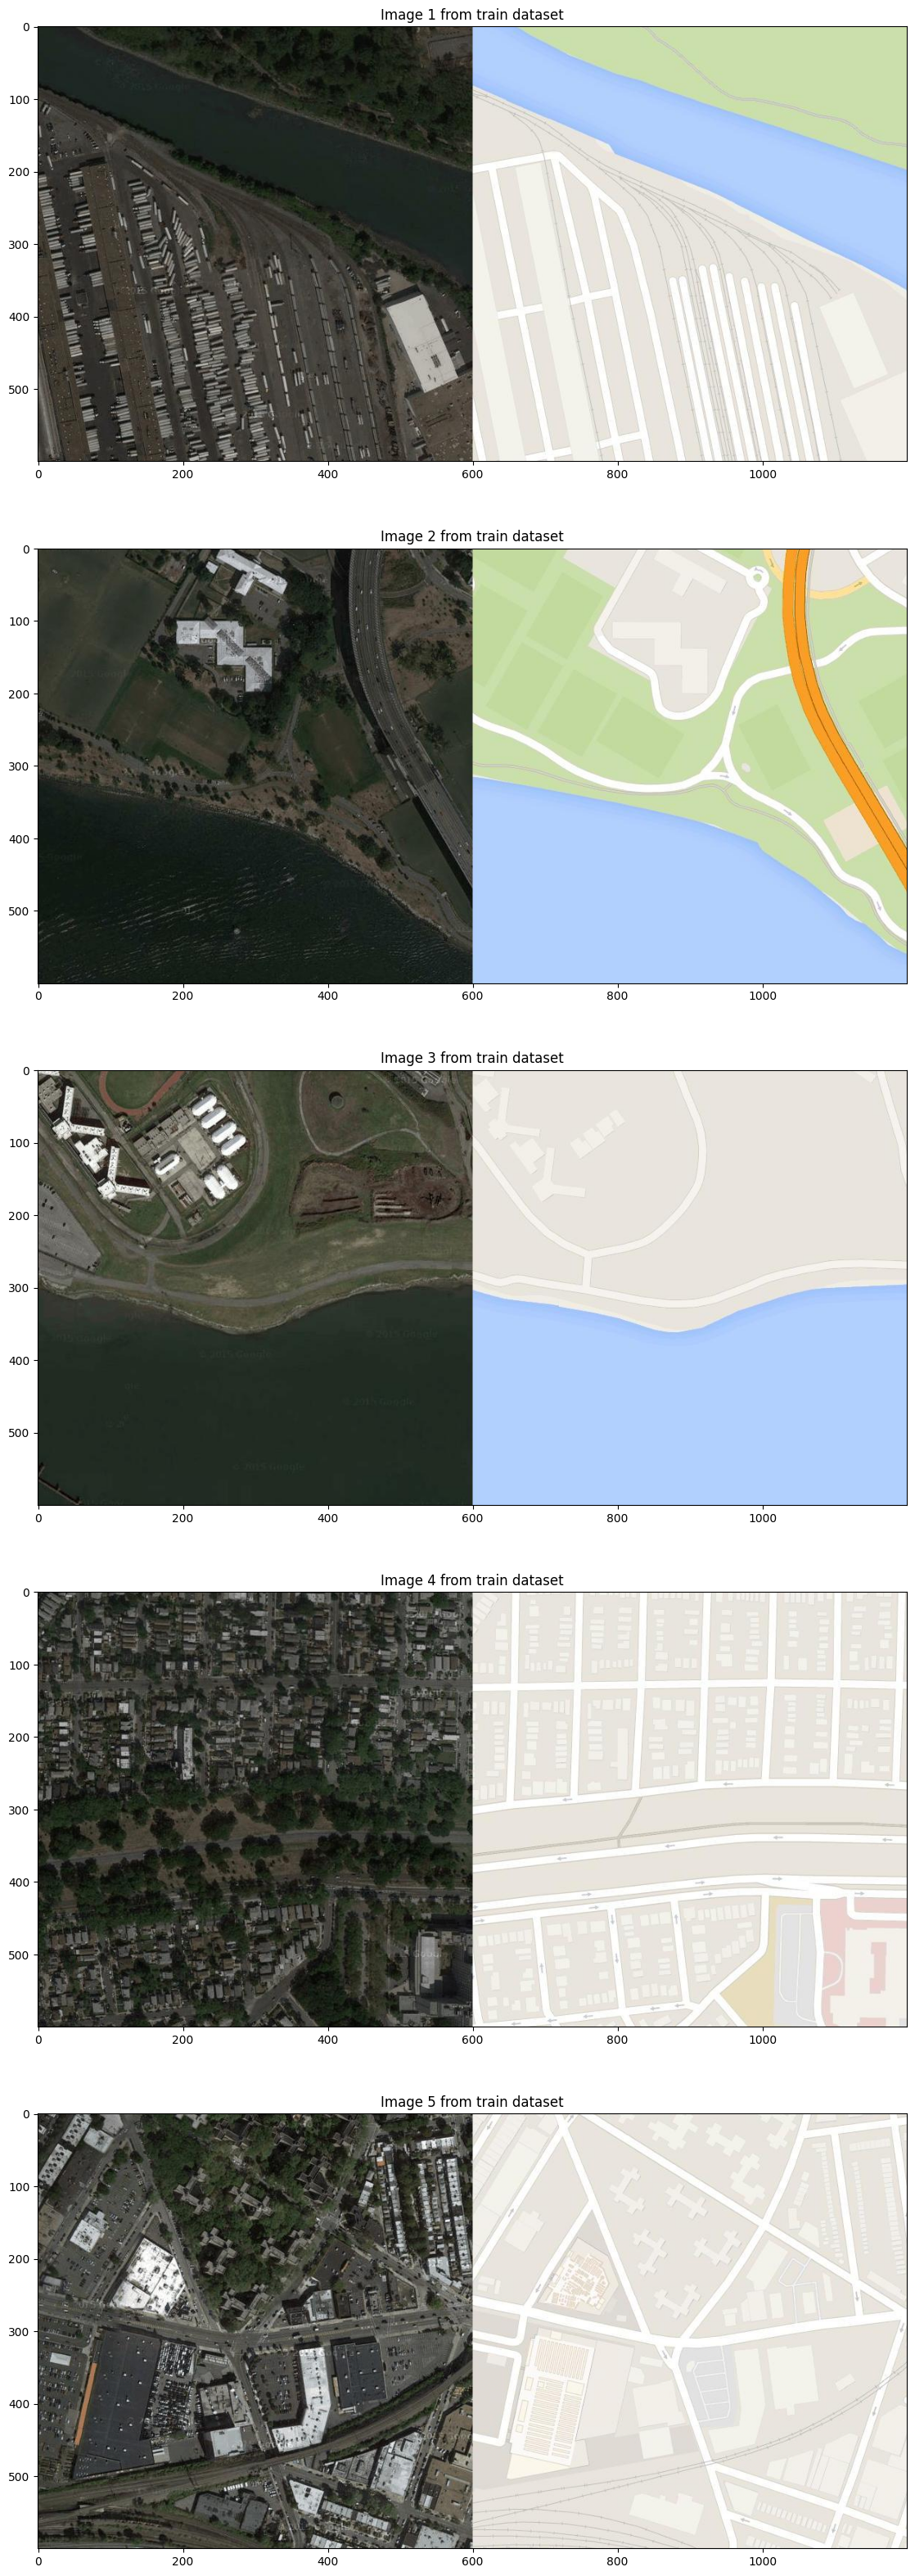

In [12]:
plt.figure(figsize=(20,40))
for i, img_path in enumerate(train_images_path[25:30]):
    plt.subplot(5,1,i+1)
    img = plt.imread(img_path)
    plt.title('Image {} from train dataset'.format(i+1))
    plt.imshow(img) 

In [13]:
img = Image.open(train_images_path[0])
print("Size of image : ", img.size)

Size of image :  (1200, 600)


<h1>2. Data Preprocessing</h1>

<h2>2.1. Splitting Data</h2>

In [14]:
# splitting the raw images into sattelite and map images
def split_images(images):
    source_images = []
    target_images = []
    for image_path in tqdm(images):
        img = load_img(path = image_path, target_size= (256,512))
        pixels = img_to_array(img)
        sat_img, map_img = pixels[:,:256], pixels[:,256:]
        source_images.append(sat_img)
        target_images.append(map_img)
    return np.asarray(source_images), np.asarray(target_images)

In [15]:
train_sat_images, train_map_images = split_images(train_images_path)

100%|█████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:05<00:00, 219.09it/s]


In [16]:
val_sat_images, val_map_images = split_images(val_images_path)

100%|█████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:06<00:00, 172.25it/s]


In [17]:
test_sat_images, test_map_images = split_images(test_images_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 143.16it/s]


In [18]:
train_sat_images.shape

(1096, 256, 256, 3)

In [19]:
train_map_images.shape

(1096, 256, 256, 3)

In [20]:
val_sat_images.shape

(1043, 256, 256, 3)

In [21]:
val_map_images.shape

(1043, 256, 256, 3)

In [22]:
test_sat_images.shape

(55, 256, 256, 3)

In [23]:
test_map_images.shape

(55, 256, 256, 3)

<h2>2.2. Data Distribution for satellite Images</h2>

In [24]:
def plot_dist(data,label):
    color = ('b','g','r')
    plt.figure(figsize=(10,10))
    for i,col in enumerate(color):
        histr = cv2.calcHist(data,[i],None,[256],[0,256])
        plt.plot(histr,color = col, label = col)
        plt.xlim([0,256])
    plt.title('Data distribution of {} Images'.format(label))
    plt.xlabel('Pixels')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

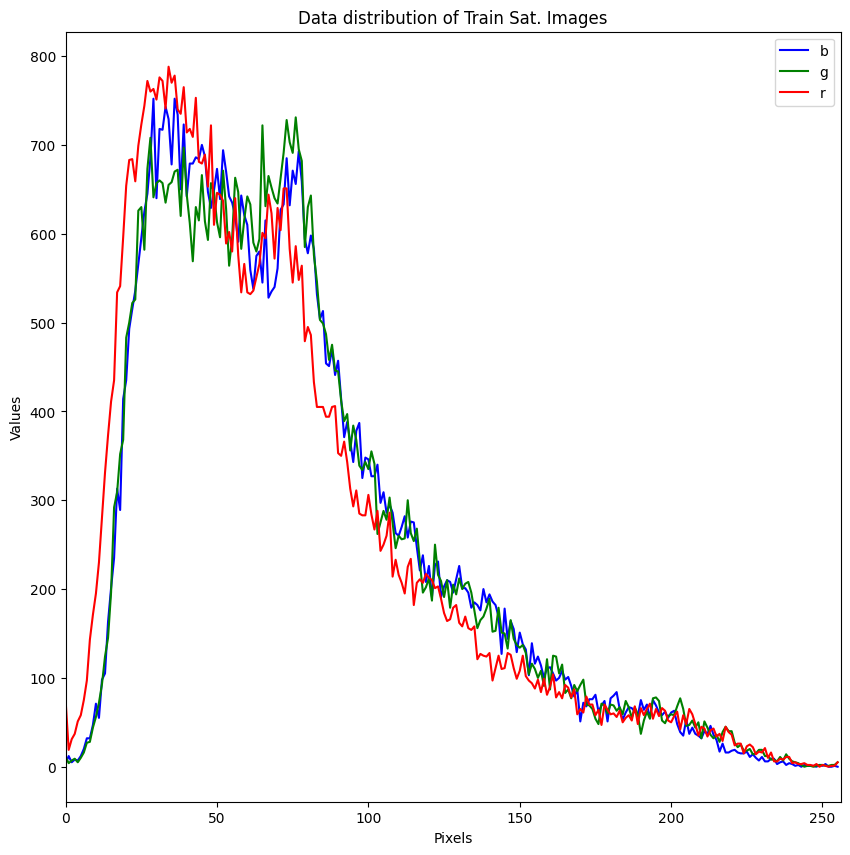

In [25]:
plot_dist(train_sat_images,'Train Sat.')

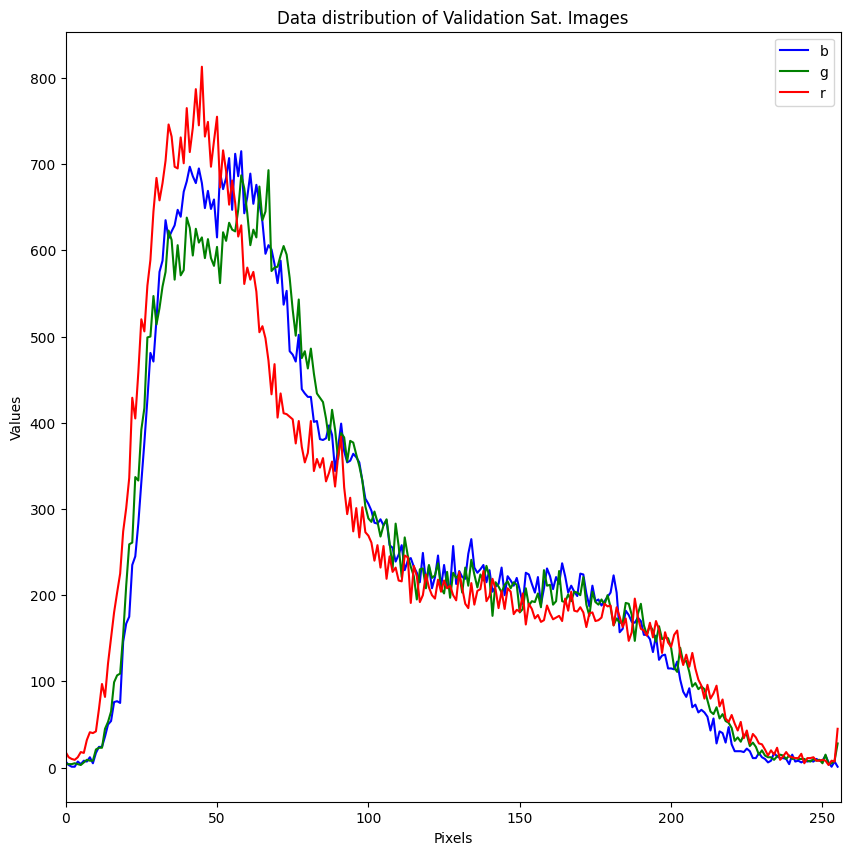

In [26]:
plot_dist(val_sat_images, 'Validation Sat.')

<h2>2.3. Scale Images</h2>

In [27]:
def scale_images(sat_images, map_images):
    sat_images = (sat_images - 127.5)/127.5
    map_images = (map_images - 127.5)/127.5
    return sat_images, map_images

In [28]:
train_sat_images, train_map_images =  scale_images(train_sat_images, train_map_images)
val_sat_images, val_map_images = scale_images(val_sat_images, val_map_images)
test_sat_images, test_map_images = scale_images(test_sat_images, test_map_images)

<h1>3. Deep Model</h1>

<h2>3.1. Install Dependencies</h2>

In [29]:
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, ReLU, Concatenate, Activation,ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

<h2>3.2. Defining Generator</h2>

In [30]:
def encoder_block(layer_in, filters, is_batch_norm = True, name = 'encoder_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv')(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X, training = True)
    X = LeakyReLU(alpha = 0.2, name = name +'_activation')(X)
    return X

In [31]:
def decoder_block(layer_in, skip_conn_layer, filters, is_dropout = True, name = 'decoder_block'):
    X = Conv2DTranspose(filters, kernel_size= (4,4), strides= (2,2), padding= 'same', kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_convT')(layer_in)
    X = BatchNormalization(name = name+'_bn')(X, training = True)
    if is_dropout:
        X = Dropout(0.5, name = name+'_dropout')(X, training = True)
    X = Concatenate(name = name +'_concat')([X, skip_conn_layer])
    X = Activation('relu', name = name+'_activation')(X)
    return X

In [32]:
def define_generator(input_shape):
    input = Input(shape = input_shape, name = 'generator_input')

    e1 = encoder_block(input, filters = 64, is_batch_norm= False, name= 'encoder_block_1')
    e2 = encoder_block(e1, filters = 128, name = 'encoder_block_2')
    e3 = encoder_block(e2, filters = 256, name = 'encoder_block_3')
    e4 = encoder_block(e3, filters = 512, name = 'encoder_block_4')
    e5 = encoder_block(e4, filters = 512, name = 'encoder_block_5')
    e6 = encoder_block(e5, filters = 512, name = 'encoder_block_6')
    e7 = encoder_block(e6, filters = 512, name = 'encoder_block_7')

    # bottleneck 
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer= RandomNormal(stddev=0.02), name = 'bottleneck_conv')(e7)
    b = Activation('relu', name= 'bottleneck_activation')(b)

    # decoder model
    d1 = decoder_block(b, skip_conn_layer= e7, filters= 512, name = 'decoder_block_1')
    d2 = decoder_block(d1, skip_conn_layer= e6, filters= 512, name = 'decoder_block_2')
    d3 = decoder_block(d2, skip_conn_layer= e5, filters= 512, name = 'decoder_block_3')
    d4 = decoder_block(d3, skip_conn_layer= e4, filters= 512, is_dropout=False, name = 'decoder_block_4')
    d5 = decoder_block(d4, skip_conn_layer= e3, filters= 256, is_dropout=False, name = 'decoder_block_5')
    d6 = decoder_block(d5, skip_conn_layer= e2, filters= 128, is_dropout= False, name = 'decoder_block_6')
    d7 = decoder_block(d6, skip_conn_layer = e1, filters=64, is_dropout= False, name = 'decoder_block_7')
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(stddev=0.02), name = 'output_conv')(d7)
    out_image = Activation('tanh', name= 'output_activation')(g)
    # define model
    model = Model(input, out_image, name ='Generator')
    return model

<h2>3.3. Defining Discriminator</h2>

In [33]:
def discriminator_block(layer_in, filters,stride =2, padding='same', is_batch_norm = True, name = 'discriminator_block'):
    X = Conv2D(filters, kernel_size= (4,4), strides= stride, padding= padding, kernel_initializer= RandomNormal(stddev= 0.02), name = name+'_conv' )(layer_in)
    if is_batch_norm:
        X = BatchNormalization(name = name+'_bn')(X)
    X = LeakyReLU(alpha = 0.2, name = name+'_leakyrelu')(X)
    return X

In [34]:
def define_discriminator(input_shape):
    in_source_image = Input(shape= input_shape, name = 'discriminator_source_image_input')
    in_target_image = Input(shape= input_shape, name = 'discriminator_target_image_input')
    discriminator_input = Concatenate()([in_source_image, in_target_image])

    d1 = discriminator_block(discriminator_input, filters= 64, is_batch_norm= False, name = 'discriminator_block_1')
    d2 = discriminator_block(d1, filters= 128, name = 'discriminator_block_2')
    d3 = discriminator_block(d2, filters = 256, name = 'discriminator_block_3')

    pad1 = ZeroPadding2D(name = 'padding_1')(d3)
    
    d4 = discriminator_block(pad1, filters= 512,stride =1,padding ='valid', name = 'discriminator_block_4')

    pad2 = ZeroPadding2D(name = 'padding_2')(d4)
    
    output_conv = Conv2D(filters= 1, kernel_size= (4,4), kernel_initializer= RandomNormal(stddev= 0.02), name='output_conv')(pad2)
    output = Activation('sigmoid')(output_conv)
    model = Model([in_source_image, in_target_image], output, name ='Discriminator')

    model.compile(loss ='binary_crossentropy', optimizer= Adam(learning_rate= 0.0002, beta_1= 0.5), loss_weights= [0.5])

    return model

<h2>3.4. Defining cGAN</h2>

In [35]:
def define_cgan(generator, discriminator, input_shape):
    for layer in discriminator.layers:
        layer.trainable = False
    
    input_source = Input(shape=input_shape, name = 'cgan_input')

    gen_out = generator(input_source)

    dis_out = discriminator([input_source, gen_out])

    model = Model(input_source, [dis_out, gen_out], name ='CGAN')

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[1,100])
    return model

<h2>3.5. Generating Samples for training</h2>

In [36]:
def generate_real_samples(sat_images, map_images, batch_size, patch_size):
    sample = np.random.randint(0,sat_images.shape[0],batch_size)
    sample_sat_image = sat_images[sample]
    sample_map_image = map_images[sample]

    y = np.ones((batch_size, patch_size, patch_size, 1))
    y = np.where(y == 1, 0.9, 1)
    return [sample_sat_image, sample_map_image] , y

In [37]:
def generate_fake_samples(sample, generator, patch_size):
    X = generator.predict(sample)
    y = np.zeros((len(X), patch_size, patch_size, 1))
    return X, y

<h2>3.6. Training</h2>

In [38]:
def summarize_performance(epoch, generator, sat_images, map_images, n_samples=3):
    # select a sample of input images
    [X_sat_image_real, X_map_image_real], _ = generate_real_samples(sat_images, map_images, n_samples, 1)
    
    # generate a batch of fake samples
    map_image_generated, _ = generate_fake_samples(X_sat_image_real, generator, 1)

    # scale all pixels from [-1,1] to [0,1]
    X_sat_image_real = (X_sat_image_real + 1) / 2.0
    X_map_image_real = (X_map_image_real + 1) / 2.0
    map_image_generated = (map_image_generated + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_sat_image_real[i])
    
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(map_image_generated[i])
    
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_map_image_real[i])
    
    # save plot to file
    filename1 = 'plot_{}_epoch{}.png'.format(epoch, epoch)
    plt.savefig(filename1)
    plt.close()
    
    # save the generator model
    filename2 = 'model_{}_epoch{}.h5'.format(epoch, epoch)
    generator.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [39]:
def train(discriminator, generator, cgan_model, sat_images, map_images, epochs = 30, batch_size = 1):
    patch_size = discriminator.output_shape[1]
    batch_per_epoch = int(len(sat_images)/ batch_size)
    steps = batch_per_epoch*epochs

    # Check if there's a previous checkpoint
    if os.path.exists('latest_checkpoint.txt'):
        with open('latest_checkpoint.txt', 'r') as f:
            last_epoch = int(f.read())
        print("Resuming training from epoch", last_epoch + 1)
        start_epoch = last_epoch + 1
    else:
        start_epoch = 0
    
    for epoch in range(start_epoch, epochs):
        print('Epoch: {}/{}'.format(epoch + 1, epochs))
        for step in range(batch_per_epoch):
            [X_sat_real, X_map_real], y_real = generate_real_samples(sat_images, map_images, batch_size, patch_size)
            X_map_fake, y_fake = generate_fake_samples(X_sat_real, generator, patch_size)

            d_loss1 = discriminator.train_on_batch([X_sat_real, X_map_real], y_real)
            d_loss2 = discriminator.train_on_batch([X_sat_real, X_map_fake], y_fake)
            
            g_loss, _, _ = cgan_model.train_on_batch(X_sat_real, [y_real, X_map_real])
            
            if ((step + 1) % 10 == 0):
                print('.', end='')
            if ((step + 1) % 100 == 0):
                print(' Batch {}/{} d_loss1:{} d_loss2:{} g_loss:{}'.format(step + 1, batch_per_epoch, d_loss1, d_loss2, g_loss))
        
        # Summarize model performance and save model after every epoch
        summarize_performance(epoch, generator, sat_images, map_images)
        
        # Save the last epoch as the latest checkpoint
        with open('latest_checkpoint.txt', 'w') as f:
            f.write(str(epoch))

In [40]:
image_shape = train_sat_images.shape[1:]

In [41]:
discriminator = define_discriminator(image_shape)
generator = define_generator(image_shape)
cgan = define_cgan(generator, discriminator, image_shape)

train(discriminator, generator, cgan, train_sat_images, train_map_images)

Resuming training from epoch 30


<h1>4. Testing Model</h1>

<h2>4.1. Load generator Model</h2>

In [42]:
#Load saved generaotr model
generator = tf.keras.models.load_model('model_29_epoch29.h5', compile=False)

In [50]:
def load_image(image_path):
    img = Image.open(image_path).resize((256, 256))
    return img

In [51]:
def preprocess(img):
    image = np.array(img)
    image = (image - 127.5)/127.5
    return image

In [52]:
def final(image_path):
    img = load_image(image_path)
    image_array = preprocess(img)
    
    img_rows, img_cols, img_channels = image_array.shape
    image_array = image_array.reshape(1, img_rows, img_cols, img_channels)

    map_image_generated = generator.predict(image_array)[0]

    map_image_generated = (map_image_generated + 1) / 2.0

    return map_image_generated

In [53]:
satellite_image_path = "test_sat_image.jpg"

In [54]:
generated_map_image = final(satellite_image_path)

1/1 [==============================] - 6s 6s/step


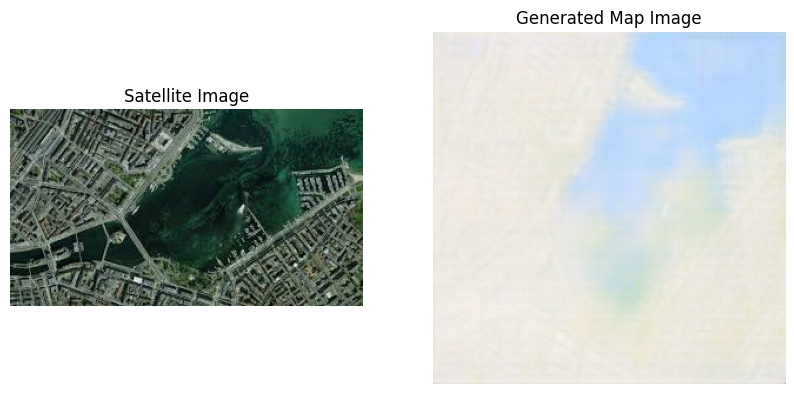

In [55]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Satellite Image')
sat_img = Image.open(satellite_image_path)
plt.imshow(sat_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Map Image')
plt.imshow(generated_map_image)
plt.axis('off')

plt.show()